# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [3]:
#%load_ext memory_profiler


In [4]:
#Going to use GPUs, as CPU on my laptop is not adequate for training dataset sizes. 
#Pre processing on CPU gives errors.

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # This setting allows incremental allocation of GPU memory
set_session(tf.Session(config = config))

#Check memory using nvidia-smi command
!nvidia-smi

Sat Jun  1 15:08:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   57C    P0    61W / 149W |     64MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


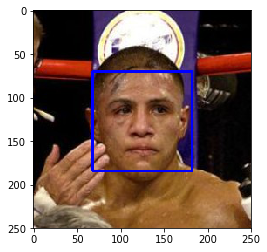

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
By invoking human face detector on first 100 images of both human and dog datasets, as per next cell:
* Percentage of human faces detected in the first 100 images in `human_files` dataset: __98%__
* Percentage of human faces detected in the first 100 images in `dog_files` dataset: __11%__


In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humancount1, humancount2 = 0, 0
for human_file in human_files_short:
    humancount1 += face_detector(human_file)
for dog_file in dog_files_short:
    humancount2 += face_detector(dog_file)
    
print("Percentage of human faces detected in 100 human_files dataset {}".format(humancount1))
print("Percentage of human faces detected in 100 dog_files dataset {}".format(humancount2))

Percentage of human faces detected in 100 human_files dataset 98
Percentage of human faces detected in 100 dog_files dataset 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

__Answer:__
Face detection with very high accuracy like 99.99% is a tough challenge for perception algorithms, though ideally one would expect to detect faces even when location, orientation of face changes within picture, even when picture is of low resolution and contains defects.

In my opinion, some of the image recognition procedures to address the issues related to accuracy are:
* Pre-processing - Apply series of transformation steps like projections, linear and non-liners transformation to standardize images into an uniform format before feeding to Neural net, to address distortions and resolution issues.
* Feature Engineering - Apply appropriate integral transformations to help feature extraction within layers.
* Input data set augmentation - Introduce into training dataset with images containing variations of faces with different locations, orientation and faces mixed with other blended in objects.

For this assignment, I will restrict myself to use OpenCV for human faces, although it is quite possible to use deep learning techniques just like we use for dog pictures.





In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* Percentage of dog faces detected in first 100 `human files` dataset is __2%__
* Percentage of dog faces detected in first 100 `dog files` dataset is __100%__

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

dog_count1, dog_count2 = 0, 0
for dog in human_files_short:
    dog_count1 += dog_detector(dog)
for dog in dog_files_short:
    dog_count2 += dog_detector(dog)
    
print("Percentage of dog faces detected in sample human files dataset: {}".format(dog_count1)) 
print("Percentage of dog faces detected in sample dog files dataset: {}".format(dog_count2))

Percentage of dog faces detected in sample human files dataset: 2
Percentage of dog faces detected in sample dog files dataset: 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.86it/s]


In [16]:
# Check memory usage after this step

!nvidia-smi

Sat Jun  1 15:13:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   63C    P0    63W / 149W |   4294MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

Steps I considered for coming up with CNN architecture for this image classification task:
* Increased depth of CNN layers proposed above by adding two extra convolutional layers, each with 128 and 256 filters, this change results in higher testing accuracy.
* Image data augmentation - Augmented both training and validation sets by adding random shifts and both vertical/horizontal flips. This process aids while training model as it allows classifier recognize more variations of images contained in training/validation datasets.
* Analysis to determine number of epochs - Did validation curve generation to determine number of epochs to train the model, this step aims at avoiding over-fitting of model.

Image classification is inherently complicated task, I won't expect first attempt in building CNN architecture with very few layers is going to give great accuracy. However, it is nice training exercise as I practice deep learning skills!


In [40]:
# let us do some image augumentation...
from keras.preprocessing.image import ImageDataGenerator

augment_train = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
augment_valid = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

augment_train.fit(train_tensors)
augment_valid.fit(valid_tensors)

### CNN Model Architecture (Training from Scratch)

In [34]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 128)       32896     
__________

### Compile the Model

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Analysis to determine number of epochs

Let us write some helper code to collect and visualize accuracy and loss curves.




In [36]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_curve(curve_path):
    curve = cv2.imread(curve_path)
    plt.figure(figsize = (15, 10))
    imgplot = plt.imshow(curve, aspect='auto')

### A reusable function to show accuracy/lot plots

In [37]:
# a function to save metrics and draw plots.
# would be useful as we experiment with many model archiectures
import pandas as pd

def plot_save_metrics(metrics, filename):
    metrics_data = pd.DataFrame(metrics.history)
    metrics_data.to_csv (filename + '.csv')
    
    plt.figure (1, figsize=(12,6))
    
    # plot of accuracy over epochs
    plt.subplot (1,2,1)
    plt.title('Accuracy plot')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(metrics.history['acc'], color = 'b')
    plt.plot(metrics.history['val_acc'], color = 'r')
    plt.legend(['Training', 'Validation'], loc='upper left')
    
    # plot of loss over epochs
    plt.subplot (1,2,2)
    plt.title('Loss plot')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(metrics.history['loss'], color = 'b')
    plt.plot(metrics.history['val_loss'], color = 'r')
    plt.legend(['Training', 'Validation'], loc='upper left')
    
    # save and display plot
    plt.savefig(filename + '.png', dpi=600)
    plt.show()
     

### Pre-train with a large number of epochs to determine optimal epochs.

In [43]:
# let us train for 150 Epochs and collect metrics
from keras.callbacks import ModelCheckpoint  
import time

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 150
batch_size = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
train_start_time = time.time()

# set this to True to fit model with out any augmentation
if False:
    model_pretrain=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
if True:
    model_pretrain=model.fit_generator(augment_train.flow(train_tensors, train_targets,  batch_size=batch_size),
                        steps_per_epoch=train_tensors.shape[0] // batch_size,
                        validation_data=augment_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                        validation_steps=valid_tensors.shape[0] // batch_size,               
                        epochs=epochs,  callbacks=[checkpointer], verbose=1)

train_end_time = time.time()

print("Training time = {0:.2f} minutes",format(round((train_end_time - train_start_time)/60.0, 2)))

Epoch 1/150
334/334 [==============================] - 58s - loss: 4.4132 - acc: 0.0499 - val_loss: 4.3857 - val_acc: 0.0488
Epoch 2/150
334/334 [==============================] - 56s - loss: 4.3194 - acc: 0.0555 - val_loss: 4.3144 - val_acc: 0.0622
Epoch 3/150
334/334 [==============================] - 56s - loss: 4.2330 - acc: 0.0621 - val_loss: 4.2557 - val_acc: 0.0720
Epoch 4/150
334/334 [==============================] - 56s - loss: 4.1625 - acc: 0.0722 - val_loss: 4.2463 - val_acc: 0.0634
Epoch 5/150
334/334 [==============================] - 56s - loss: 4.0826 - acc: 0.0838 - val_loss: 4.1817 - val_acc: 0.0671
Epoch 6/150
334/334 [==============================] - 57s - loss: 4.0235 - acc: 0.0846 - val_loss: 4.1738 - val_acc: 0.0671
Epoch 7/150
334/334 [==============================] - 56s - loss: 3.9525 - acc: 0.0991 - val_loss: 4.0628 - val_acc: 0.0829
Epoch 8/150
334/334 [==============================] - 56s - loss: 3.8936 - acc: 0.1039 - val_loss: 4.0605 - val_acc: 0.0841


334/334 [==============================] - 57s - loss: 3.0610 - acc: 0.2469 - val_loss: 3.3509 - val_acc: 0.1976
Epoch 29/150
334/334 [==============================] - 57s - loss: 3.0239 - acc: 0.2524 - val_loss: 3.4434 - val_acc: 0.2061
Epoch 30/150
334/334 [==============================] - 56s - loss: 3.0131 - acc: 0.2546 - val_loss: 3.3286 - val_acc: 0.2073
Epoch 31/150
334/334 [==============================] - 56s - loss: 2.9677 - acc: 0.2654 - val_loss: 3.4505 - val_acc: 0.1829
Epoch 32/150
334/334 [==============================] - 56s - loss: 2.9486 - acc: 0.2719 - val_loss: 3.3826 - val_acc: 0.2207
Epoch 33/150
334/334 [==============================] - 57s - loss: 2.9317 - acc: 0.2740 - val_loss: 3.4669 - val_acc: 0.1902
Epoch 34/150
334/334 [==============================] - 56s - loss: 2.8888 - acc: 0.2816 - val_loss: 3.5243 - val_acc: 0.1890
Epoch 35/150
334/334 [==============================] - 58s - loss: 2.8931 - acc: 0.2793 - val_loss: 3.4807 - val_acc: 0.1866
Epoch

334/334 [==============================] - 56s - loss: 2.4238 - acc: 0.3765 - val_loss: 3.2700 - val_acc: 0.2378
Epoch 61/150
334/334 [==============================] - 57s - loss: 2.4049 - acc: 0.3823 - val_loss: 3.1976 - val_acc: 0.2598
Epoch 62/150
334/334 [==============================] - 56s - loss: 2.3813 - acc: 0.3858 - val_loss: 3.0504 - val_acc: 0.2646
Epoch 63/150
334/334 [==============================] - 56s - loss: 2.3462 - acc: 0.3988 - val_loss: 3.3400 - val_acc: 0.2293
Epoch 64/150
334/334 [==============================] - 56s - loss: 2.3429 - acc: 0.3916 - val_loss: 3.3874 - val_acc: 0.2646
Epoch 65/150
334/334 [==============================] - 56s - loss: 2.3279 - acc: 0.4015 - val_loss: 3.2221 - val_acc: 0.2732
Epoch 66/150
334/334 [==============================] - 56s - loss: 2.3132 - acc: 0.3982 - val_loss: 3.1716 - val_acc: 0.2732
Epoch 67/150
334/334 [==============================] - 56s - loss: 2.3123 - acc: 0.4013 - val_loss: 3.3344 - val_acc: 0.2366
Epoch

334/334 [==============================] - 57s - loss: 2.0467 - acc: 0.4578 - val_loss: 3.0182 - val_acc: 0.2720
Epoch 94/150
334/334 [==============================] - 57s - loss: 2.0217 - acc: 0.4648 - val_loss: 3.4299 - val_acc: 0.2866
Epoch 95/150
334/334 [==============================] - 56s - loss: 2.0401 - acc: 0.4609 - val_loss: 3.2744 - val_acc: 0.3098
Epoch 96/150
334/334 [==============================] - 57s - loss: 2.0121 - acc: 0.4660 - val_loss: 2.9762 - val_acc: 0.3305
Epoch 97/150
334/334 [==============================] - 57s - loss: 2.0106 - acc: 0.4747 - val_loss: 3.3029 - val_acc: 0.2732
Epoch 98/150
334/334 [==============================] - 57s - loss: 2.0152 - acc: 0.4630 - val_loss: 3.1650 - val_acc: 0.3183
Epoch 99/150
334/334 [==============================] - 57s - loss: 2.0116 - acc: 0.4672 - val_loss: 3.2596 - val_acc: 0.2720
Epoch 100/150
334/334 [==============================] - 56s - loss: 1.9754 - acc: 0.4775 - val_loss: 3.0440 - val_acc: 0.2890
Epoc

334/334 [==============================] - 57s - loss: 1.8619 - acc: 0.5055 - val_loss: 3.2196 - val_acc: 0.2890
Epoch 127/150
334/334 [==============================] - 57s - loss: 1.8864 - acc: 0.4973 - val_loss: 3.2904 - val_acc: 0.2951
Epoch 128/150
334/334 [==============================] - 57s - loss: 1.8390 - acc: 0.5001 - val_loss: 3.0848 - val_acc: 0.3232
Epoch 129/150
334/334 [==============================] - 57s - loss: 1.8735 - acc: 0.5043 - val_loss: 3.1783 - val_acc: 0.3146
Epoch 130/150
334/334 [==============================] - 56s - loss: 1.8050 - acc: 0.5145 - val_loss: 3.3021 - val_acc: 0.2756
Epoch 131/150
334/334 [==============================] - 56s - loss: 1.8661 - acc: 0.5054 - val_loss: 3.1825 - val_acc: 0.2951
Epoch 132/150
334/334 [==============================] - 56s - loss: 1.8268 - acc: 0.5133 - val_loss: 3.5326 - val_acc: 0.2963
Epoch 133/150
334/334 [==============================] - 56s - loss: 1.8284 - acc: 0.5088 - val_loss: 3.0680 - val_acc: 0.328

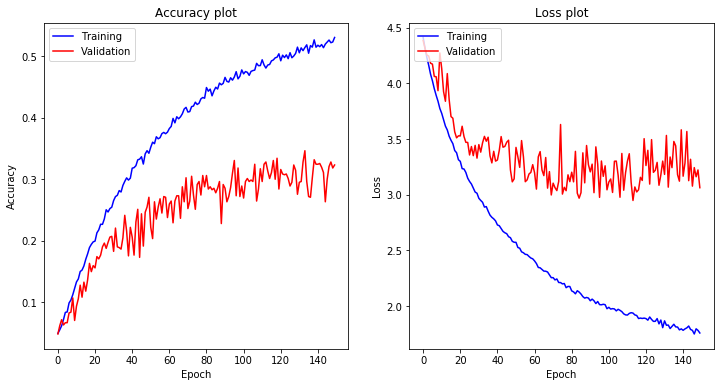

In [44]:
plot_save_metrics(model_pretrain, 'pretrain_cnn_metrics')

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

### Pre-traininng plot analysis

The above plots show the model accuracy and loss function v.s. number epochs for the training and validation sets r The run was implemented with a total of 150 epochs and a batch size of 20 samples. The validation loss decays in-between 1 and 80 epochs with significant gains in accuracy. The model shows signs of overfitting when using more than 80 epochs, as the validation loss shows no improvement beyond 80 epochs. This suggest using a maximum 80 epochs for model training. Overall accuracy is not as great, but not bad for first attempt at CNN architecture from scratch.



### Actual training

In [45]:
from keras.callbacks import ModelCheckpoint  
import time

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 80
batch_size = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
train_start_time = time.time()

# set this to True to fit model with out any augmentation
if False:
    model_pretrain=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
if True:
    model_pretrain=model.fit_generator(augment_train.flow(train_tensors, train_targets,  batch_size=batch_size),
                        steps_per_epoch=train_tensors.shape[0] // batch_size,
                        validation_data=augment_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                        validation_steps=valid_tensors.shape[0] // batch_size,               
                        epochs=epochs,  callbacks=[checkpointer], verbose=1)

train_end_time = time.time()

print("Training time = {0:.2f} minutes",format(round((train_end_time - train_start_time)/60.0, 2)))

Epoch 1/80
334/334 [==============================] - 58s - loss: 1.7800 - acc: 0.5223 - val_loss: 3.0189 - val_acc: 0.3183
Epoch 2/80
334/334 [==============================] - 56s - loss: 1.7436 - acc: 0.5341 - val_loss: 3.1034 - val_acc: 0.3329
Epoch 3/80
334/334 [==============================] - 56s - loss: 1.7581 - acc: 0.5290 - val_loss: 3.3386 - val_acc: 0.2878
Epoch 4/80
334/334 [==============================] - 56s - loss: 1.7475 - acc: 0.5278 - val_loss: 3.9573 - val_acc: 0.3061
Epoch 5/80
334/334 [==============================] - 56s - loss: 1.7473 - acc: 0.5298 - val_loss: 3.1938 - val_acc: 0.3280
Epoch 6/80
334/334 [==============================] - 56s - loss: 1.7406 - acc: 0.5205 - val_loss: 2.9768 - val_acc: 0.3549
Epoch 7/80
334/334 [==============================] - 56s - loss: 1.8040 - acc: 0.5254 - val_loss: 3.3348 - val_acc: 0.3244
Epoch 8/80
334/334 [==============================] - 56s - loss: 1.7533 - acc: 0.5287 - val_loss: 3.2749 - val_acc: 0.3171
Epoch 9/

334/334 [==============================] - 56s - loss: 1.6806 - acc: 0.5584 - val_loss: 3.6390 - val_acc: 0.3354
Epoch 34/80
334/334 [==============================] - 56s - loss: 1.6874 - acc: 0.5479 - val_loss: 3.1829 - val_acc: 0.3268
Epoch 35/80
334/334 [==============================] - 56s - loss: 1.6953 - acc: 0.5469 - val_loss: 3.9068 - val_acc: 0.3232
Epoch 36/80
334/334 [==============================] - 56s - loss: 1.7120 - acc: 0.5446 - val_loss: 3.4462 - val_acc: 0.3000
Epoch 37/80
334/334 [==============================] - 56s - loss: 1.7127 - acc: 0.5400 - val_loss: 4.0472 - val_acc: 0.2915
Epoch 38/80
334/334 [==============================] - 56s - loss: 1.7117 - acc: 0.5439 - val_loss: 3.4742 - val_acc: 0.3439
Epoch 39/80
334/334 [==============================] - 56s - loss: 1.6927 - acc: 0.5445 - val_loss: 3.3162 - val_acc: 0.3256
Epoch 40/80
334/334 [==============================] - 56s - loss: 1.7041 - acc: 0.5395 - val_loss: 3.4466 - val_acc: 0.3183
Epoch 41/80


334/334 [==============================] - 56s - loss: 1.7071 - acc: 0.5407 - val_loss: 3.2799 - val_acc: 0.3439
Epoch 68/80
334/334 [==============================] - 56s - loss: 1.7202 - acc: 0.5407 - val_loss: 3.4519 - val_acc: 0.2939
Epoch 69/80
334/334 [==============================] - 56s - loss: 1.7084 - acc: 0.5412 - val_loss: 3.3248 - val_acc: 0.3390
Epoch 70/80
334/334 [==============================] - 57s - loss: 1.6954 - acc: 0.5513 - val_loss: 3.4159 - val_acc: 0.3024
Epoch 71/80
334/334 [==============================] - 56s - loss: 1.7261 - acc: 0.5413 - val_loss: 3.2122 - val_acc: 0.3207
Epoch 72/80
334/334 [==============================] - 56s - loss: 1.7406 - acc: 0.5373 - val_loss: 3.2017 - val_acc: 0.3195
Epoch 73/80
334/334 [==============================] - 57s - loss: 1.7214 - acc: 0.5418 - val_loss: 3.5718 - val_acc: 0.2951
Epoch 74/80
334/334 [==============================] - 56s - loss: 1.7450 - acc: 0.5404 - val_loss: 3.5851 - val_acc: 0.3280
Epoch 75/80


### Load the Model with the Best Validation Loss

In [46]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [47]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 37.4402%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [48]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [49]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
import time

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [50]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Pre-train analysis:

In [65]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 300
batch_size = 20

vgg16_train_st_time = time.time()

if True:
    VGG_stats=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=300, batch_size=20, callbacks=[checkpointer], verbose=1)

if False:
    VGG_stats=VGG16_model.fit_generator(augment_train.flow(train_VGG16, train_targets, batch_size=batch_size),
                                        steps_per_epoch=train_VGG16.shape[0] // batch_size,
                                        validaton_data=augment_valid.flow(valid_VGG16, valid_targets, batch_size=batch_size),
                                        validation_steps=valid_VGG16.shape[0] // batch_size,
                                        epochs=epochs, verbose=1, callbacks=[checkpointer])

vgg16_train_end_time = time.time()


Train on 6680 samples, validate on 835 samples
Epoch 1/300
6680/6680 [==============================] - 1s - loss: 8.4233 - acc: 0.4722 - val_loss: 9.0167 - val_acc: 0.3892
Epoch 2/300
6680/6680 [==============================] - 1s - loss: 8.4136 - acc: 0.4751 - val_loss: 8.9236 - val_acc: 0.3952
Epoch 3/300
6680/6680 [==============================] - 1s - loss: 8.4098 - acc: 0.4759 - val_loss: 8.8796 - val_acc: 0.4036
Epoch 4/300
6680/6680 [==============================] - 1s - loss: 8.3967 - acc: 0.4741 - val_loss: 9.0078 - val_acc: 0.3916
Epoch 5/300
6680/6680 [==============================] - 1s - loss: 8.3635 - acc: 0.4762 - val_loss: 8.9220 - val_acc: 0.3892
Epoch 6/300
6680/6680 [==============================] - 1s - loss: 8.3464 - acc: 0.4778 - val_loss: 8.9005 - val_acc: 0.4012
Epoch 7/300
6680/6680 [==============================] - 1s - loss: 8.3361 - acc: 0.4793 - val_loss: 8.9909 - val_acc: 0.3964
Epoch 8/300
6680/6680 [==============================] - 1s - loss: 8.2

6680/6680 [==============================] - 1s - loss: 7.1926 - acc: 0.5519 - val_loss: 8.0162 - val_acc: 0.4455
Epoch 30/300
6680/6680 [==============================] - 1s - loss: 7.1911 - acc: 0.5528 - val_loss: 7.9903 - val_acc: 0.4515
Epoch 31/300
6680/6680 [==============================] - 1s - loss: 7.1880 - acc: 0.5530 - val_loss: 8.0246 - val_acc: 0.4503
Epoch 32/300
6680/6680 [==============================] - 1s - loss: 7.1849 - acc: 0.5534 - val_loss: 8.0266 - val_acc: 0.4455
Epoch 33/300
6680/6680 [==============================] - 1s - loss: 7.1809 - acc: 0.5539 - val_loss: 8.0203 - val_acc: 0.4455
Epoch 34/300
6680/6680 [==============================] - 1s - loss: 7.1779 - acc: 0.5540 - val_loss: 7.9867 - val_acc: 0.4467
Epoch 35/300
6680/6680 [==============================] - 1s - loss: 7.1783 - acc: 0.5539 - val_loss: 8.0215 - val_acc: 0.4503
Epoch 36/300
6680/6680 [==============================] - 1s - loss: 7.1737 - acc: 0.5545 - val_loss: 8.0686 - val_acc: 0.44

6680/6680 [==============================] - 1s - loss: 6.8010 - acc: 0.5757 - val_loss: 7.8041 - val_acc: 0.4623
Epoch 61/300
6680/6680 [==============================] - 1s - loss: 6.7916 - acc: 0.5760 - val_loss: 7.8680 - val_acc: 0.4611
Epoch 62/300
6680/6680 [==============================] - 1s - loss: 6.7892 - acc: 0.5762 - val_loss: 7.8317 - val_acc: 0.4683
Epoch 63/300
6680/6680 [==============================] - 1s - loss: 6.7856 - acc: 0.5775 - val_loss: 7.8239 - val_acc: 0.4563
Epoch 64/300
6680/6680 [==============================] - 1s - loss: 6.7822 - acc: 0.5784 - val_loss: 7.7657 - val_acc: 0.4623
Epoch 65/300
6680/6680 [==============================] - 1s - loss: 6.7795 - acc: 0.5787 - val_loss: 7.7811 - val_acc: 0.4707
Epoch 66/300
6680/6680 [==============================] - 1s - loss: 6.7759 - acc: 0.5792 - val_loss: 7.7482 - val_acc: 0.4731
Epoch 67/300
6680/6680 [==============================] - 1s - loss: 6.7772 - acc: 0.5790 - val_loss: 7.7364 - val_acc: 0.46

6680/6680 [==============================] - 1s - loss: 6.7707 - acc: 0.5799 - val_loss: 7.8068 - val_acc: 0.4695
Epoch 92/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7636 - val_acc: 0.4671
Epoch 93/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7505 - val_acc: 0.4647
Epoch 94/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5798 - val_loss: 7.7609 - val_acc: 0.4671
Epoch 95/300
6680/6680 [==============================] - 1s - loss: 6.7727 - acc: 0.5798 - val_loss: 7.7556 - val_acc: 0.4671
Epoch 96/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7417 - val_acc: 0.4683
Epoch 97/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7678 - val_acc: 0.4671
Epoch 98/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7570 - val_acc: 0.46

6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7226 - val_acc: 0.4707
Epoch 125/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7121 - val_acc: 0.4707
Epoch 126/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5798 - val_loss: 7.7343 - val_acc: 0.4719
Epoch 127/300
6680/6680 [==============================] - 1s - loss: 6.7714 - acc: 0.5798 - val_loss: 7.7566 - val_acc: 0.4671
Epoch 128/300
6680/6680 [==============================] - 1s - loss: 6.7726 - acc: 0.5798 - val_loss: 7.7132 - val_acc: 0.4683
Epoch 129/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7125 - val_acc: 0.4659
Epoch 130/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7196 - val_acc: 0.4659
Epoch 131/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7316 - val_ac

6680/6680 [==============================] - 1s - loss: 6.7723 - acc: 0.5798 - val_loss: 7.7265 - val_acc: 0.4671
Epoch 158/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7260 - val_acc: 0.4671
Epoch 159/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7261 - val_acc: 0.4671
Epoch 160/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7314 - val_acc: 0.4683
Epoch 161/300
6680/6680 [==============================] - 1s - loss: 6.7719 - acc: 0.5798 - val_loss: 7.7292 - val_acc: 0.4671
Epoch 162/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7334 - val_acc: 0.4659
Epoch 163/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7391 - val_acc: 0.4659
Epoch 164/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7377 - val_ac

6680/6680 [==============================] - 1s - loss: 6.7723 - acc: 0.5798 - val_loss: 7.7409 - val_acc: 0.4659
Epoch 190/300
6680/6680 [==============================] - 1s - loss: 6.7723 - acc: 0.5798 - val_loss: 7.7454 - val_acc: 0.4671
Epoch 191/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7044 - val_acc: 0.4707
Epoch 192/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7271 - val_acc: 0.4683
Epoch 193/300
6680/6680 [==============================] - 1s - loss: 6.7718 - acc: 0.5796 - val_loss: 7.7303 - val_acc: 0.4671
Epoch 194/300
6680/6680 [==============================] - 1s - loss: 6.7715 - acc: 0.5798 - val_loss: 7.7487 - val_acc: 0.4671
Epoch 195/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5796 - val_loss: 7.7391 - val_acc: 0.4683
Epoch 196/300
6680/6680 [==============================] - 1s - loss: 6.7724 - acc: 0.5798 - val_loss: 7.7460 - val_ac

6680/6680 [==============================] - 1s - loss: 6.7723 - acc: 0.5798 - val_loss: 7.7596 - val_acc: 0.4671
Epoch 223/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7590 - val_acc: 0.4671
Epoch 224/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7592 - val_acc: 0.4671
Epoch 225/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7783 - val_acc: 0.4671
Epoch 226/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7671 - val_acc: 0.4671
Epoch 227/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7619 - val_acc: 0.4635
Epoch 228/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7462 - val_acc: 0.4671
Epoch 229/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7539 - val_ac

6680/6680 [==============================] - 1s - loss: 6.7724 - acc: 0.5798 - val_loss: 7.7428 - val_acc: 0.4659
Epoch 256/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7434 - val_acc: 0.4659
Epoch 257/300
6680/6680 [==============================] - 1s - loss: 6.7724 - acc: 0.5798 - val_loss: 7.7376 - val_acc: 0.4683
Epoch 258/300
6680/6680 [==============================] - 1s - loss: 6.7720 - acc: 0.5798 - val_loss: 7.7347 - val_acc: 0.4695
Epoch 259/300
6680/6680 [==============================] - 1s - loss: 6.7721 - acc: 0.5798 - val_loss: 7.7232 - val_acc: 0.4695
Epoch 260/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7417 - val_acc: 0.4683
Epoch 261/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7439 - val_acc: 0.4683
Epoch 262/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7462 - val_ac

6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7380 - val_acc: 0.4683
Epoch 289/300
6680/6680 [==============================] - 1s - loss: 6.7723 - acc: 0.5798 - val_loss: 7.7380 - val_acc: 0.4683
Epoch 290/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7412 - val_acc: 0.4671
Epoch 291/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7410 - val_acc: 0.4671
Epoch 292/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7433 - val_acc: 0.4671
Epoch 293/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7504 - val_acc: 0.4683
Epoch 294/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7461 - val_acc: 0.4683
Epoch 295/300
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7442 - val_ac

NameError: name 'vgg16_st_time' is not defined

In [66]:
vgg16_train_time = vgg16_train_end_time - vgg16_train_st_time
print("VGG16 training time = {0:.2f} minutes".format(round(vgg16_train_time/60.0, 2)))

VGG16 training time = 7.76 minutes


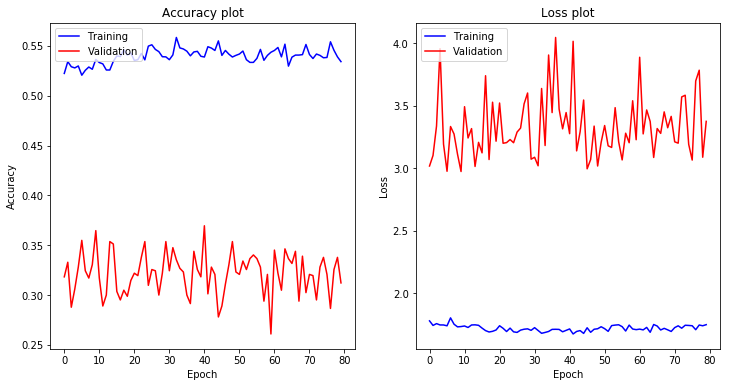

In [67]:
plot_save_metrics(model_pretrain, 'pretrain_VGG16_metrics')

From the plots of the VGG16 pre-trained model accuracy and loss function v.s. number epochs for the training and validation sets for pre-training epoch determination analysis with large number of epochs at 300, it is evident that the validation loss is oscillating between 3 and 4 for 1 and 300 epochs with no significant gains in accuracy. This suggests that further training is not necessary and not going to affect loss or accuracy, so I chose to train with 20 epochs.

### Train the Model

In [69]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 20
batch_size = 20

vgg16_train_st_time = time.time()

if True:
    VGG_stats=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

if False:
    VGG_stats=VGG16_model.fit_generator(augment_train.flow(train_VGG16, train_targets, batch_size=batch_size),
                                        steps_per_epoch=train_VGG16.shape[0] // batch_size,
                                        validaton_data=augment_valid.flow(valid_VGG16, valid_targets, batch_size=batch_size),
                                        validation_steps=valid_VGG16.shape[0] // batch_size,
                                        epochs=epochs, verbose=1, callbacks=[checkpointer])

vgg16_train_end_time = time.time()


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7482 - val_acc: 0.4683
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7551 - val_acc: 0.4695
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5798 - val_loss: 7.7566 - val_acc: 0.4707
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 6.7720 - acc: 0.5796 - val_loss: 7.7583 - val_acc: 0.4695
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7578 - val_acc: 0.4695
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 6.7724 - acc: 0.5798 - val_loss: 7.7552 - val_acc: 0.4695
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 6.7722 - acc: 0.5796 - val_loss: 7.7449 - val_acc: 0.4719
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 6.7722 - ac

In [70]:
vgg16_train_time = vgg16_train_end_time - vgg16_train_st_time
print("VGG16 training time = {0:.2f} minutes".format(round(vgg16_train_time/60.0, 2)))

VGG16 training time = 0.52 minutes


### Load the Model with the Best Validation Loss

In [71]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [72]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.2488%


### Predict Dog Breed with the Model

In [73]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [74]:
def image_classifier_vgg16(predictor, image_file):
    image = cv2.imread(image_file)
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imageplot = plt.imshow(cv_rgb)
    
    # check for human face
    if face_detector(image_file):
        prediction = predictor(image_file)
        breed = prediction
        print("Human face deteced in this image, this human looks like a {}".format(breed))
    elif dog_detector(image_file):
        prediction = predictor(image_file)
        breed = prediction
        print("Dog face detected in this image, this dog looks like a {}".format(breed))
    else:
        print("No dog or human face detected in this image")

### Predict with few sample dog images

Dog face detected in this image, this dog looks like a Labrador_retriever


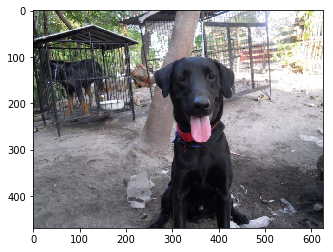

In [75]:
image_classifier_vgg16(VGG16_predict_breed,'images/Labrador_retriever_06449.jpg')

Dog face detected in this image, this dog looks like a Brittany


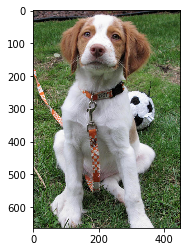

In [76]:
image_classifier_vgg16(VGG16_predict_breed,'images/Brittany_02625.jpg')

Dog face detected in this image, this dog looks like a German_wirehaired_pointer


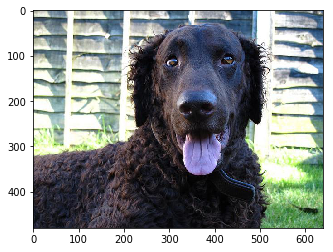

In [77]:
image_classifier_vgg16(VGG16_predict_breed,'images/Curly-coated_retriever_03896.jpg')

Dog face detected in this image, this dog looks like a Basset_hound


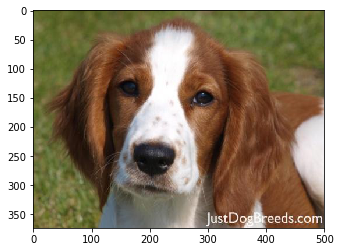

In [78]:
image_classifier_vgg16(VGG16_predict_breed,'images/Welsh_springer_spaniel_08203.jpg')

Dog face detected in this image, this dog looks like a Labrador_retriever


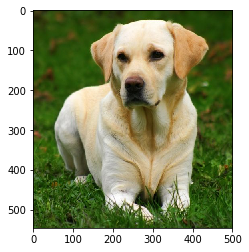

In [79]:
image_classifier_vgg16(VGG16_predict_breed,'images/Labrador_retriever_06457.jpg')

### Analysis of predictions

VGG16 model provides as trained is at 47.24% accuracy, so tried predicting with some sample dog images. Out of 5 samples, it correctly classifed 3 of them, with accuracy of at 60%. Not sure if we can further fine tune this CNN, as number of epochs is not adding any significant improvement to accuracy or reducting loss.

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [80]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import numpy as np

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

* Augumented training set is used for this training as well, with hopes of increasing accuracy and model performance.

* As ResNet50 network is training for visual recognition with different dataset, we can't directly use it for dog classification problem. However, bottleneck layer can be thought of useful abstraction up to kth layer. I will use that as base layer for architecture and customize on top of it by adding layers specific to dog classification problem.

* I will add layer with Global Average Pooling, which will reduce each of the feature maps to singular values.
* I will add a final Dense layer with number of outputs matching with categories of dog breeds we want, essentially making this multi-class classification problem. I will use softmax activation function so that we get the class with highest probability.

* Accuracy expected here is much better than training model from scratch, as ResNet50 is trained extensively for visual patter recognition problems, essentially we are reusing all the great work already put in place.










In [81]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation
from keras.models import Sequential

Res_model = Sequential()
Res_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Res_model.add(Dense(133, activation='softmax'))

Res_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [82]:
### TODO: Compile the model.
from keras.optimizers import Adamax

Res_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.01), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  


You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [86]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint
import time

checkpoint = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', verbose = 1, save_best_only = True)

param_epochs = 20
param_batch_size = 20
r50_train_start_time = time.time()

if True:
    resnet50 = Res_model.fit(train_Resnet50, 
                         train_targets,
                         validation_data = (valid_Resnet50, valid_targets),
                         epochs= param_epochs,
                         batch_size = param_batch_size,
                         callbacks = [checkpoint],
                         verbose = 1)
    
if False:
    resnet50 = Res_model.fit_generator(augment_train.flow(train_Resnet50, train_targets, batch_size=batch_size),
                  steps_per_epoch=train_Resnet50.shape[0] // batch_size,
                  validation_data=augment_vaid.flow (valid_ResNet50, valid_targets, batch_size=batch_size),
                  validation_steps=valid_ResNet50.shape[0] // batch_size,
                  epochs=epochs, verbose=1, callback=[checkpointer])                     
    

r50_train_end_time = time.time()
r50_train_time = r50_train_end_time - r50_train_start_time

print("Training time = {0:.2f} minutes ".format(round(r50_train_time/60.0, 2)))

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.7437 - acc: 0.6135 - val_loss: 0.8828 - val_acc: 0.7389
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.2900 - acc: 0.9126 - val_loss: 0.8183 - val_acc: 0.7772
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.1391 - acc: 0.9608 - val_loss: 0.6885 - val_acc: 0.7904
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.0704 - acc: 0.9874 - val_loss: 0.6414 - val_acc: 0.8180
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.0429 - acc: 0.9948 - val_loss: 0.6333 - val_acc: 0.8204
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0296 - acc: 0.9978 - val_loss: 0.6634 - val_acc: 0.8036
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0236 - acc: 0.9963 - val_loss: 0.6300 - val_acc: 0.8311
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0177 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [88]:
### TODO: Load the model weights with the best validation loss.
Res_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [90]:
### TODO: Calculate classification accuracy on the test dataset.

Res_predictions = [np.argmax(Res_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
test_acc = 10 * np.sum(np.array(Res_predictions) == np.argmax(test_targets, axis = 1)/len(Res_predictions))
print('Accuracy on test dataset: %.3f%%}' % test_acc)

Accuracy on test dataset: 60.000%}


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [91]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import extract_Resnet50

def resnet50_predict_dog_breed(image):
    bn_feature = extract_Resnet50(path_to_tensor(image))
    prediction_vector = Res_model.predict(bn_feature)
    return dog_names[np.argmax(prediction_vector)]
    

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [92]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def image_classifier(predictor, image_file):
    image = cv2.imread(image_file)
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imageplot = plt.imshow(cv_rgb)
    
    # check for human face
    if face_detector(image_file):
        prediction = predictor(image_file)
        breed = prediction
        print("Human face deteced in this image, this human looks like a {}".format(breed))
    elif dog_detector(image_file):
        prediction = predictor(image_file)
        breed = prediction
        print("Dog face detected in this image, this dog looks like a {}".format(breed))
    else:
        print("No dog or human face detected in this image")
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

__Results__

* Tested the algorithm with several images, results:
  - For images containing dogs, output is accurate and much better than training from scratch model, predictions with 6 dog sample pictures matched dog breeds correctly.
  - Used 2 images of human faces, the algorithm detected human faces correctly.
  - For negative testing, I used image of a wolf and a bear, the algorithm incorrectly recognized them as human face! I think human face detector can be enhanced using deep learning techniques similar to dog breed predictions.
  - Algorth correctly recoginized image of cat and that of a CNN architecture correctly as niether dog nor a human.
  - Overall this algorithm performed much better than I expected, really fun and interesting learning project!
  
__Points for improvement:__
* Fine tuning to better classify animals resembling dogs, possibly writing separate face detectors for species closely resembling dogs, and combining their scores like we do ensemble learning techniques.
* Dataset augmentation with wide color variations and mixing with similar objects, so that algorithm learns to recognize subtle features in the mix of significant variations. Potentially use Generative Adversarial Networks.
* Segment images to allow algorithm to detect and classify more than one face in image, for instance if an image has many breeds of dogs. This would need object recognition, segmentation, and extraction of each object followed by feature standardization pipelines.

In [93]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os
for file in os.listdir('images'):
    #print("filename {}".format(file))
    print("image_classifier(resnet50_predict_dog_breed, 'images/{}')".format(file))

image_classifier(resnet50_predict_dog_breed, 'images/sample_cnn.png')
image_classifier(resnet50_predict_dog_breed, 'images/Labrador_retriever_06449.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/0422-britney-spears-getty-4.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/Brittany_02625.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/sample_dog_output.png')
image_classifier(resnet50_predict_dog_breed, 'images/many_dogs.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/American_water_spaniel_00648.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/Curly-coated_retriever_03896.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/Welsh_springer_spaniel_08203.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/MJackson.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/scary_cat.jpg')
image_classifier(resnet50_predict_dog_breed, 'images/sample_human_output.png')
image_classifier(resnet50_predict_dog_breed, 'images/Labrad

Dog face detected in this image, this dog looks like a Labrador_retriever


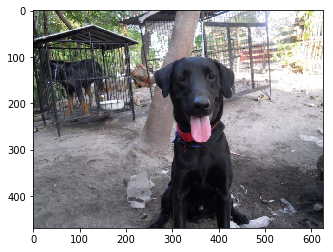

In [94]:
image_classifier(resnet50_predict_dog_breed, 'images/Labrador_retriever_06449.jpg')

Dog face detected in this image, this dog looks like a Brittany


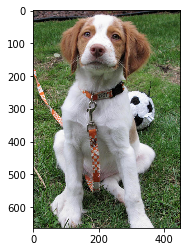

In [95]:
image_classifier(resnet50_predict_dog_breed, 'images/Brittany_02625.jpg')


Dog face detected in this image, this dog looks like a Labrador_retriever


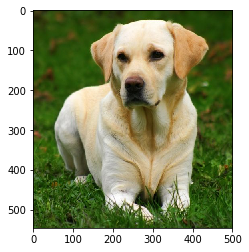

In [96]:
image_classifier(resnet50_predict_dog_breed, 'images/Labrador_retriever_06457.jpg')


Dog face detected in this image, this dog looks like a Welsh_springer_spaniel


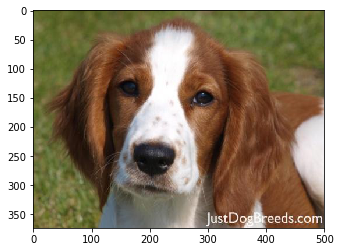

In [97]:
image_classifier(resnet50_predict_dog_breed, 'images/Welsh_springer_spaniel_08203.jpg')


Dog face detected in this image, this dog looks like a Labrador_retriever


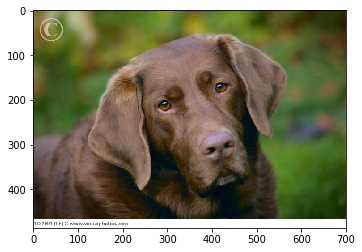

In [98]:
image_classifier(resnet50_predict_dog_breed, 'images/Labrador_retriever_06455.jpg')


Dog face detected in this image, this dog looks like a Curly-coated_retriever


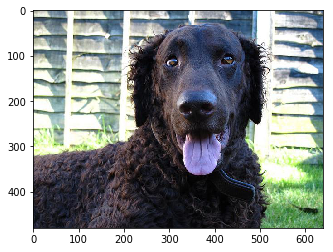

In [99]:
image_classifier(resnet50_predict_dog_breed, 'images/Curly-coated_retriever_03896.jpg')


Human face deteced in this image, this human looks like a Silky_terrier


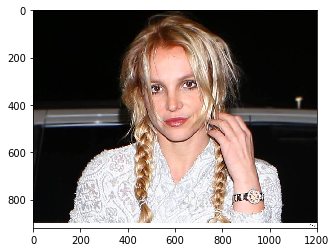

In [100]:
image_classifier(resnet50_predict_dog_breed, 'images/0422-britney-spears-getty-4.jpg')


Human face deteced in this image, this human looks like a English_toy_spaniel


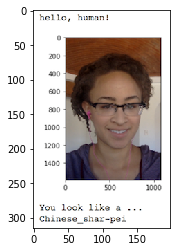

In [101]:
image_classifier(resnet50_predict_dog_breed, 'images/sample_human_output.png')


No dog or human face detected in this image


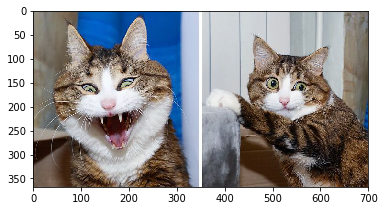

In [102]:
image_classifier(resnet50_predict_dog_breed, 'images/scary_cat.jpg')


No dog or human face detected in this image


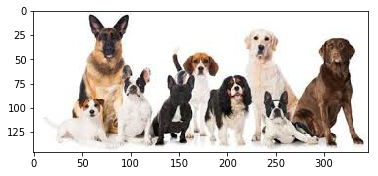

In [103]:
image_classifier(resnet50_predict_dog_breed, 'images/many_dogs.jpg')


Human face deteced in this image, this human looks like a Chow_chow


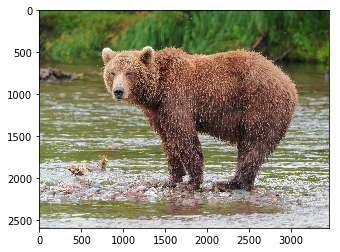

In [104]:
image_classifier(resnet50_predict_dog_breed, 'images/Brown_bear.jpg')


Human face deteced in this image, this human looks like a Alaskan_malamute


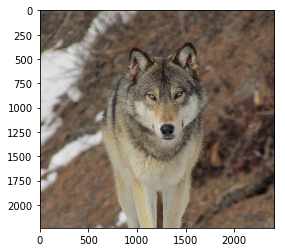

In [105]:
image_classifier(resnet50_predict_dog_breed, 'images/Wolf.jpg')


No dog or human face detected in this image


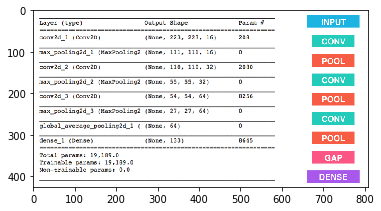

In [106]:
image_classifier(resnet50_predict_dog_breed, 'images/sample_cnn.png')
